# Workflow Notebook
This notebook is intended to present models which are loaded from other files as well as the results they allow us to reach. It goes through the following steps:
* Defining Global Variables
* Loading Word Embeddings
* Loading Data
* Preprocessing Data
    * Correcting Spelling Mistakes
    * Spliting Training and Testing Data
    * Tokenizing Data
    * Building and Refining Embeddings Array
* Model definition
* Model training
* Model testing and evaluation

In [1]:
import csv
import gensim
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from gensim.models import Word2Vec
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import sequence, text
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm

Using TensorFlow backend.


## Define Global Variables

In [2]:
RANDOM_SEED = 42
NB_CATEGORIES = 51

PADDING = 100
PRE_TRAINED_DIM = 300

TRAINABLE = True # Training the embedding can lead to overfitting

dataDirPath = './challenge_data'
embeddingsDirPath = './../word_embeddings/'
xPath = os.path.join(dataDirPath, 'input_train.csv')
yPath = os.path.join(dataDirPath, 'output_train.csv')
xTestPath = os.path.join(dataDirPath, 'input_test.csv')
#embeddingPath = os.path.join(embeddingsDirPath, 'wiki.fr.vec')
#embeddingPath = os.path.join(embeddingsDirPath, 'retrained_fr.vec')
embeddingPath = os.path.join(embeddingsDirPath, 'retrained_questions.vec')

## Loading Word Embeddings
Load from fasttext or EMEA.

In [ ]:
pretrainedEmbeddings = gensim.models.KeyedVectors.\
    load_word2vec_format(embeddingPath, binary=False)

## Loading Data

In [ ]:
x = pd.read_csv(xPath, delimiter=';', usecols=[1]).values.ravel()
xTest = pd.read_csv(xTestPath, delimiter=';', usecols=[1]).values.ravel()
y = pd.read_csv(yPath, delimiter=';', usecols=[1]).values.ravel()

## Preprocessing Data

### Correcting Spelling Mistakes

In [ ]:
correctionsDict = {}
correctionsPath = os.path.join(dataDirPath, 'corrections.csv')

with open(correctionsPath, 'r') as f:
    for key, val in csv.reader(f):
        correctionsDict[key] = val

def spellingCorrection(sentence, correctionsDict={}, verbose=False):
    correctedSentence = []
    nb_corrections = 0
    for word in sentence.split():
        if word in correctionsDict.keys():
            word = correctionsDict[word]
            nb_corrections += 1
        correctedSentence.append(word)
    if verbose:
        return ' '.join(correctedSentence), nb_corrections
    else:
        return ' '.join(correctedSentence)

nb_corr = 0
for i, s in enumerate(x):
    cor = spellingCorrection(s, correctionsDict, verbose = True)
    x[i] = cor[0]
    nb_corr += cor[1]

for i, s in enumerate(xTest):
    cor = spellingCorrection(s, correctionsDict, verbose = True)
    xTest[i] = cor[0]
    nb_corr += cor[1]
print(nb_corr)

### Tokenizing Data

In [ ]:
tokenizer = text.Tokenizer(
    num_words=1e5,
    filters="!\"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'´’™©®«»",
    split=" "
)

tokenizer.fit_on_texts(np.concatenate((x, xTest)))
vocabulary = tokenizer.word_index.keys()

In [ ]:
print('Vocabulary size: ', len(vocabulary))

### Downsampling Categories

In [ ]:
def downsample(x, y, threshold=None, show=False):
    nb_categories = len(set(y))
    if threshold is None:
        countCategories = [0] * nb_categories
        for point in y:
            countCategories[point] += 1
        indexedCountCategories = list(zip(list(range(nb_categories)), countCategories))
        selectedCategories = list(filter(lambda x: x[1] > 100, indexedCountCategories))
        #threshold = np.percentile([cat[1] for cat in selectedCategories], 75)
        threshold = np.mean([cat[1] for cat in selectedCategories])
    print('Thresholding each category to {} datapoints.'.format(threshold))
    X = []
    Y = []
    count_categories = np.zeros(nb_categories)
    for xx, yy in zip(x, y):
        if count_categories[yy] <= threshold:
            X.append(xx)
            Y.append(yy)
            count_categories[yy]+=1
    X = np.array(X)
    Y = np.array(Y)
    if show == True:
        plt.figure(figsize=(15, 5))
        plt.hist(Y, bins=nb_categories, label='train labels', density=False, alpha=1)
        plt.axis
        plt.legend()
        plt.show()
    return X, Y

In [ ]:
x, y = downsample(x, y, threshold=2000, show=True)

### Parsing Inputs And Outputs

In [ ]:
x = tokenizer.texts_to_sequences(x)
x = sequence.pad_sequences(x, PADDING)
xTest = tokenizer.texts_to_sequences(xTest)
xTest = sequence.pad_sequences(xTest, PADDING)

y = to_categorical(y, num_classes=NB_CATEGORIES)

### Spliting Training And Validation Data

In [ ]:
xTrain, xValid, yTrain, yValid = train_test_split(x, y, test_size=.2,
                                                  random_state=RANDOM_SEED)

### Building And Refining Embedding Array

#### Loading Medic Names

In [ ]:
MEDICAMENTS = []

with open(os.path.join(dataDirPath, 'medicList.txt')) as f:
    for line in f:
        MEDICAMENTS.append(line.lower().rstrip())

print('Liste de médicaments regroupant les libéllés ATC et les'
      'dénominations de spécialité, de taille: {}'.format(len(MEDICAMENTS)))
print('Sample of medicament names: ', MEDICAMENTS[:10])

## Building model

#### Building Embeddings

In [ ]:
from unidecode import unidecode

In [ ]:
embeddings = np.zeros((len(vocabulary) + 1 , PRE_TRAINED_DIM))
not_in_pretrained = []
detected_medic = []

for word, idx in tokenizer.word_index.items():
    if word not in pretrainedEmbeddings.vocab:
        unaccented = unidecode(word)
        if word in MEDICAMENTS:
            vec = pretrainedEmbeddings['médicament']
            detected_medic.append(word)
        else:
            vec = np.zeros(PRE_TRAINED_DIM)
            not_in_pretrained.append(word)
    else:
        vec = pretrainedEmbeddings[word]

    # word_to_index is 1-based! the 0-th row, used for padding, stays at zero
    embeddings[idx,] = vec

In [ ]:
print('---------- Embedding Created ----------')
print('Number of words in corpus that do not appear in '
      'pretrained Fasttext: ', len(not_in_pretrained))
print('size of the embedding: {}'.format(embeddings.shape))

#### Reducing Embeddings Dimension

In [ ]:
from sklearn.decomposition import PCA
REDUCED_DIM = 100

pca = PCA(n_components=REDUCED_DIM)
reducedEmbeddings = pca.fit_transform(embeddings)

## Model Definition

### Generic Methods

In [ ]:
class CustomModel():
    '''Generic workflow class.'''

    def __init__(self, **kwargs):
        self.verbose = kwargs.get('verbose', False)

        self.nbCategories = kwargs['nbCategories']
        self.paddingLength = PADDING
        self.trainable = kwargs.get('trainable', False)

    def train(self, x, y, epochs= 10, batch_size=32, validation_data=None, callback=False):
        if callback == True:
            filepath= '../models_checkpoints/weights-{epoch:02d}-{val_acc:.3f}.hdf5'
            checkpoint = ModelCheckpoint(filepath, monitor='val_acc',
                                         verbose=1, save_best_only=True, mode='max')
            callbacks_list = [checkpoint]

            return self.model.fit(x, y, shuffle='batch', epochs=epochs,
                                  verbose=1 if self.verbose else 0,
                                  batch_size=batch_size, validation_data=validation_data,
                                  callbacks=callbacks_list)
        else:
            return self.model.fit(x, y, shuffle='batch', epochs=epochs,
                                  verbose=1 if self.verbose else 0,
                                  batch_size=batch_size, validation_data=validation_data)

    def evaluate(self, x, y):
        return self.model.evaluate(x, y)

    def predict(self, x):
        return self.model.predict(x)

### Mathematical Model
Here, we implement several models (CNN, RNN, etc) with different shapes.

In [ ]:
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras import Input
from keras.layers import Input, Conv1D, Dense, Dropout, GlobalMaxPooling1D, MaxPooling1D

class CustomModel(CustomModel):
    '''Extended CustomModel'''

    def buildCNN1D(self, embedding, drop_rates=[.3, .3], nb_filters=128,
                   filter_size=4, padding=PADDING):
        self.embedding = embedding

        my_input = keras.Input(shape=(self.paddingLength,), name= 'input')

        embedding = (Embedding(input_dim=self.embedding.shape[0],
                               output_dim=self.embedding.shape[1],
                               weights=[self.embedding],
                               input_length=self.paddingLength,
                               trainable=self.trainable,
                               name='embedding'))(my_input)
        embedding_dropped = Dropout(drop_rates[0], name='drop0')(embedding)

        conv1 = Conv1D(nb_filters, filter_size,
                       activation='relu', name='conv1')(embedding_dropped)
    
        pooled1 = MaxPooling1D(pool_size=3, strides=None, name='pool1')

        conv2 = Conv1D(nb_filters, filter_size,
                       activation='relu', name='conv2')(conv1)

        pooled2 = GlobalMaxPooling1D(name='pool2')(conv2)
    
        dropped1 = Dropout(drop_rates[1], name='drop1')(pooled2)
        
        prob = Dense(self.nbCategories, activation='softmax', name='softmax')(dropped1)
        
        self.model = Model(my_input, prob)

        self.model.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )

In [ ]:
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras import Input
from keras.layers import (Input, Conv2D, Dense, Dropout,
                          MaxPooling2D, Flatten, Concatenate, Reshape)


class CustomModel(CustomModel):
    '''Extended CustomModel'''

    def buildCNN2D(self, embedding, drop_rates=[.3, .3] , nb_filters=128,
                   filter_size=[2,3,4], padding=PADDING):
        self.embedding = embedding

        my_input = Input(shape=(self.paddingLength, ), name= 'input')

        embedding = Embedding(input_dim=self.embedding.shape[0],
                               output_dim=self.embedding.shape[1],
                               weights=[self.embedding],
                               input_length=self.paddingLength,
                               trainable=self.trainable,
                               name='embedding')(my_input)
        embedding = Reshape((padding, self.embedding.shape[1], 1))(embedding)
        embedding_dropped = Dropout(drop_rates[0], name='drop0')(embedding)
        
        # one concatenates 3 filter sizes
        conv0 = Conv2D(nb_filters, (filter_size[0], self.embedding.shape[1]),
                       activation='relu', name='conv0', padding='valid')(embedding_dropped)
        pooled0 = MaxPooling2D(pool_size=(padding - filter_size[0] + 1, 1),
                               strides=(1, 1), padding='valid', name='pool0')(conv0)
        
        conv1 = Conv2D(nb_filters, (filter_size[1], self.embedding.shape[1]),
                       activation='relu', name='conv1', padding='valid')(embedding_dropped)
        pooled1 = MaxPooling2D(pool_size = (padding - filter_size[1] + 1, 1),
                               strides=(1, 1), padding='valid', name='pool1')(conv1)
        
        conv2 = Conv2D(nb_filters, (filter_size[2], self.embedding.shape[1]),
                       activation='relu', name='conv2', padding='valid')(embedding_dropped)
        pooled2 = MaxPooling2D(pool_size = (padding - filter_size[2] + 1, 1),
                               strides=(1, 1), padding='valid', name='pool2')(conv2)
        
        concatenated = Concatenate(axis=1)([pooled0, pooled1, pooled2])
        flattened = keras.layers.Flatten()(concatenated)
        dropped1 = Dropout(drop_rates[1], name='drop1')(flattened)  
        prob = Dense(self.nbCategories, activation='softmax', name='dense2')(dropped1)

        self.model = Model(my_input, prob)

        self.model.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )

In [ ]:
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras import Input
from keras.layers import LSTM, Embedding, Dropout


class CustomModel(CustomModel):
    '''Extended CustomModel'''
    
    def buildLSTM(self, embedding, drop_rate=0.3, nb_filters=128, filter_size=3):
        self.embedding = embedding

        my_input = Input(shape=(self.paddingLength,), name= 'input')

        embedding = Embedding(input_length=self.paddingLength,
                                input_dim=self.embedding.shape[0],
                                output_dim=self.embedding.shape[1],
                                weights=[self.embedding],
                                trainable=self.trainable,
                                name='embedding')(my_input)

        embedding_dropped = Dropout(drop_rate, name='drop0')(embedding)
        lstm1 = LSTM(100, name = 'lstm1', dropout= drop_rate,
                     recurrent_dropout= drop_rate)(embedding_dropped)
        dense1 = Dense(self.nbCategories, activation = 'relu', name = 'dense1')(lstm1)
        prob = Dense(self.nbCategories, activation='softmax', name='softmax')(dense1)

        self.model = Model(my_input, prob)

        self.model.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )

In [ ]:
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras import Input
from keras.layers import MaxPooling1D, LSTM, Conv1D


class CustomModel(CustomModel):
    '''Extended CustomModel'''
    
    def buildLSTM_CNN(self, embedding, drop_rate=0.3, nb_filters=128, filter_size=3):
        self.embedding = embedding

        my_input = Input(shape=(self.paddingLength,), name= 'input')

        embedding = Embedding(input_length=self.paddingLength,
                                input_dim=self.embedding.shape[0],
                                output_dim=self.embedding.shape[1],
                                weights=[self.embedding],
                                trainable=self.trainable,
                                name='embedding')(my_input)

        embedding_dropped = Dropout(drop_rate, name='drop0')(embedding)
        conv1 = Conv1D(nb_filters, filter_size, activation='relu',
                       name='conv1', padding='same')(embedding_dropped)
        pooled1 = MaxPooling1D(pool_size = 2, name = 'pool1')(conv1)
        dropped1 = Dropout(drop_rate, name = 'drop1')(pooled1)
        lstm1 = LSTM(100, name = 'lstm1',
                     dropout= drop_rate, recurrent_dropout= drop_rate)(dropped1)
        prob = Dense(self.nbCategories,
                     activation='softmax', name='dense1')(lstm1)

        self.model = Model(my_input, prob)

        self.model.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )

## Model training

In [ ]:
def plotHistory(history):
    plt.figure(figsize=(15,8))

    plt.subplot(121)
    plt.plot(history['acc'], label='Accuracy')
    plt.plot(history['val_acc'], label='Validaction Accuracy')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.subplot(122)
    plt.plot(history['loss'], label='Loss')
    plt.plot(history['val_loss'], label='Validaction Loss')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    plt.show()

In [119]:
DROP_RATES = [.3, .4]
NB_FILTERS = 256
FILTER_SIZE = 3

trainingHistory = {}

model = CustomModel(verbose=True, nbCategories=NB_CATEGORIES, trainable=TRAINABLE)
# model.buildCNN1D(reducedEmbeddings, drop_rates=DROP_RATES, nb_filters=NB_FILTERS,
#                  filter_size=FILTER_SIZE)
model.buildCNN2D(reducedEmbeddings, drop_rates=DROP_RATES, nb_filters=NB_FILTERS)
model.model.summary()
print('Total number of model parameters:', model.model.count_params())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 100)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 110)     1119360     input[0][0]                      
__________________________________________________________________________________________________
reshape_66 (Reshape)            (None, 100, 110, 1)  0           embedding[0][0]                  
__________________________________________________________________________________________________
drop0 (Dropout)                 (None, 100, 110, 1)  0           reshape_66[0][0]                 
__________________________________________________________________________________________________
conv0 (Con

In [124]:
BATCH_SIZE = 256
EPOCHS = 15

trainingPartialHistory = model.train(xTrain, yTrain, epochs=EPOCHS, batch_size=BATCH_SIZE,
                                     validation_data=(xValid, yValid), callback=True)

for key in trainingPartialHistory.history:
    if key in trainingHistory:
        trainingHistory[key] += trainingPartialHistory.history[key]
    else:
        trainingHistory[key] = trainingPartialHistory.history[key]

Train on 6422 samples, validate on 1606 samples
Epoch 1/15
6422/6422 [==============================] - 19s 3ms/step - loss: 0.1069 - acc: 0.9707 - val_loss: 1.3093 - val_acc: 0.7198

Epoch 00001: val_acc improved from -inf to 0.71980, saving model to ../models_checkpoints/weights-01-0.72.hdf5
Epoch 2/15
6422/6422 [==============================] - 18s 3ms/step - loss: 0.1046 - acc: 0.9706 - val_loss: 1.3161 - val_acc: 0.7217

Epoch 00002: val_acc improved from 0.71980 to 0.72167, saving model to ../models_checkpoints/weights-02-0.72.hdf5
Epoch 3/15
6422/6422 [==============================] - 18s 3ms/step - loss: 0.1058 - acc: 0.9721 - val_loss: 1.3122 - val_acc: 0.7242

Epoch 00003: val_acc improved from 0.72167 to 0.72416, saving model to ../models_checkpoints/weights-03-0.72.hdf5
Epoch 4/15
6422/6422 [==============================] - 17s 3ms/step - loss: 0.0968 - acc: 0.9759 - val_loss: 1.3154 - val_acc: 0.7248

Epoch 00004: val_acc improved from 0.72416 to 0.72478, saving model t

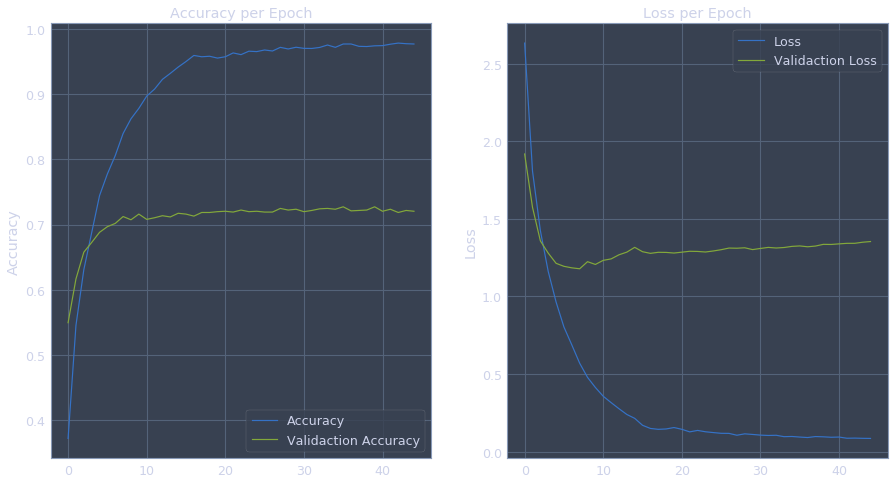

In [125]:
plotHistory(trainingHistory)

## Grid Search Cross Validation
* Embedding dimension
* Padding
* Multiple dropout rates

### Save CV Results

In [28]:
def saveCV(saveFileName, data):
    with open('./../cross_validation/{}'.format(saveFileName), 'w+') as f:
        writer = csv.writer(f, delimiter=';')
        for line in data:
            writer.writerow(line)

In [70]:
def plotAccCV(acc_path, val_acc_path, labels):
    plt.figure(figsize=(15,8))

    accs = []
    with open(acc_path, 'r') as f:
        reader = csv.reader(f, delimiter=';')
        for row in reader:
            accs.append(list(map(float, row)))

    val_accs = []
    with open(val_acc_path, 'r') as f:
        reader = csv.reader(f, delimiter=';')
        for row in reader:
            val_accs.append(list(map(float, row)))

    epochsList = list(range(len(val_accs[0])))

    plt.subplot(121)
    for i, acc in enumerate(accs):
        plt.plot(epochsList, acc, label=labels[i])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

    plt.subplot(122)
    for i, val_acc in enumerate(val_accs):
        plt.plot(epochsList, val_acc, label=labels[i])
    plt.ylabel('Val Accuracy')
    plt.xlabel('Epoch')

    plt.legend()
    # plt.title('Effect of Embedding Size on Accuracy')

    plt.show()

### Embedding Size
* 50:301:50
```
BATCH_SIZE = 32
DROP_RATES = [.4, .4]
NB_FILTERS = 256
EPOCHS = 11
```

In [89]:
embeddingCV = range(50, 301, 50)
BATCH_SIZE = 32
DROP_RATES = [.3, .4]
NB_FILTERS = 256
EPOCHS = 11

histories = []
for dim in tqdm(embeddingCV):
    pcaCV = PCA(n_components=dim)
    reducedEmbeddingsCV = pcaCV.fit_transform(embeddings)

    model = CustomModel(verbose=False, nbCategories=NB_CATEGORIES, trainable=TRAINABLE)
    model.buildCNN2D(reducedEmbeddingsCV, drop_rates=DROP_RATES, nb_filters=NB_FILTERS)

    history = model.train(xTrain, yTrain, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          validation_data=(xValid, yValid))
    histories.append(history)

  0%|          | 0/6 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [41]:
saveFileName = 'acc_embeddings_50_301_50.txt'
saveCV(saveFileName, [history.history['acc'] for history in histories])
saveFileName = 'val_acc_embeddings_50_301_50.txt'
saveCV(saveFileName, [history.history['val_acc'] for history in histories])

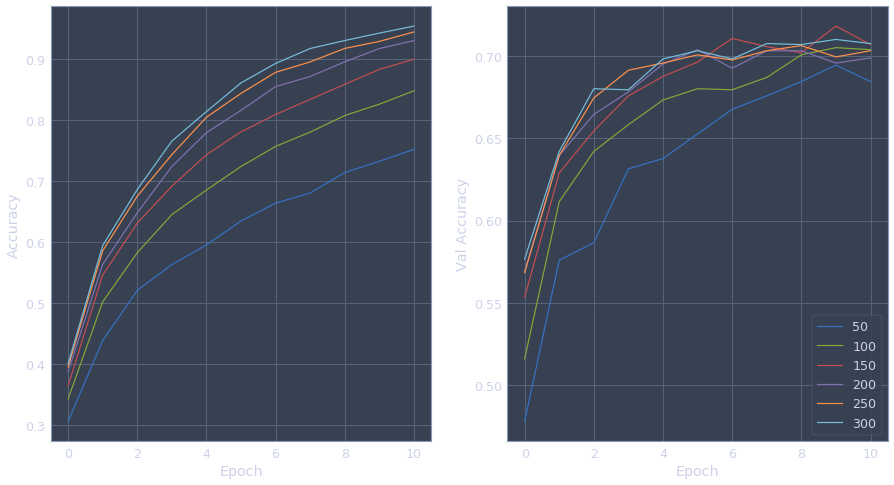

In [73]:
plotAccCV('./../cross_validation/acc_embeddings_50_301_50.txt',
          './../cross_validation/val_acc_embeddings_50_301_50.txt',
          list(embeddingCV))

### Dropout rate
```
BATCH_SIZE = 32
REDUCED_DIM = 100
NB_FILTERS = 256
EPOCHS = 10
```

In [80]:
DROP_RATES = [(round(a,2), .4) for a in np.linspace(0.2,0.5,num=7)]
BATCH_SIZE = 32
REDUCED_DIM = 100
NB_FILTERS = 256
EPOCHS = 10

histories = []
for a,b in tqdm(DROP_RATES):
    pcaCV = PCA(n_components=REDUCED_DIM)
    reducedEmbeddingsCV = pcaCV.fit_transform(embeddings)

    model = CustomModel(verbose=False, nbCategories=NB_CATEGORIES, trainable=TRAINABLE)
    model.buildCNN2D(reducedEmbeddingsCV, drop_rates=[a,b], nb_filters=NB_FILTERS)

    history = model.train(xTrain, yTrain, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          validation_data=(xValid, yValid))
    histories.append(history)

100%|██████████| 7/7 [19:00<00:00, 162.87s/it]


In [81]:
saveFileName = 'acc_drop_rate_1.txt'
saveCV(saveFileName, [history.history['acc'] for history in histories])
saveFileName = 'val_acc_drop_rate_1.txt'
saveCV(saveFileName, [history.history['val_acc'] for history in histories])

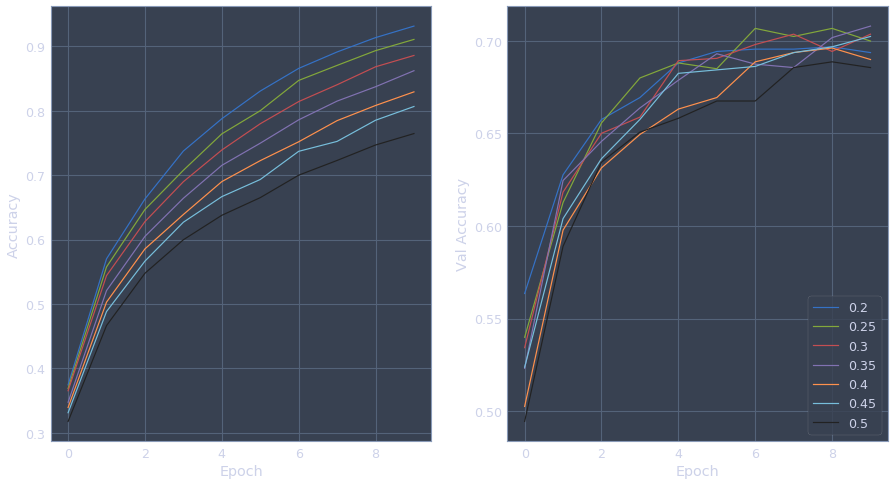

In [82]:
plotAccCV('./../cross_validation/acc_drop_rate_1.txt',
          './../cross_validation/val_acc_drop_rate_1.txt',
          list(map(lambda x: round(x,2), np.linspace(0.2,0.5,num=7))))

In [86]:
DROP_RATES = [(.35, a) for a in np.linspace(0.2,0.5,num=7)]
BATCH_SIZE = 32
REDUCED_DIM = 100
NB_FILTERS = 256
EPOCHS = 10

histories = []
for a,b in tqdm(DROP_RATES):
    pcaCV = PCA(n_components=REDUCED_DIM)
    reducedEmbeddingsCV = pcaCV.fit_transform(embeddings)

    model = CustomModel(verbose=False, nbCategories=NB_CATEGORIES, trainable=TRAINABLE)
    model.buildCNN2D(reducedEmbeddingsCV, drop_rates=[a,b], nb_filters=NB_FILTERS)

    history = model.train(xTrain, yTrain, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          validation_data=(xValid, yValid))
    histories.append(history)

100%|██████████| 7/7 [1:35:32<00:00, 818.98s/it]   


In [87]:
saveFileName = 'acc_drop_rate_2.txt'
saveCV(saveFileName, [history.history['acc'] for history in histories])
saveFileName = 'val_acc_drop_rate_2.txt'
saveCV(saveFileName, [history.history['val_acc'] for history in histories])

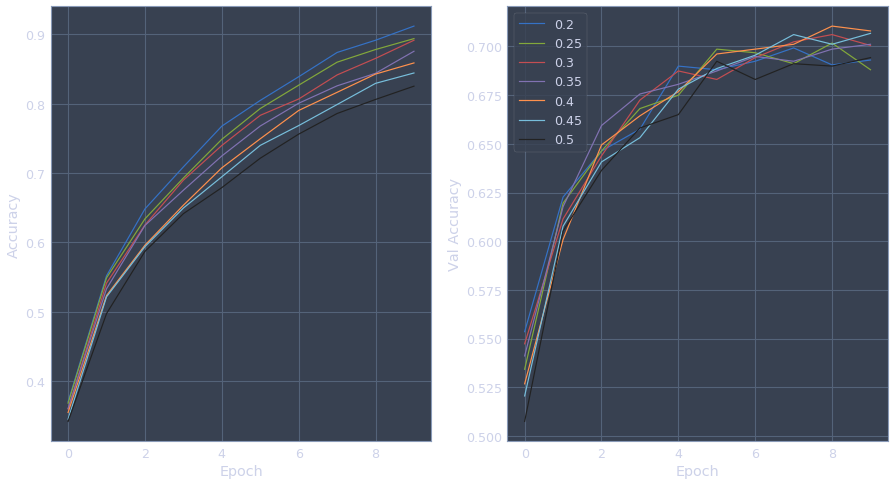

In [88]:
plotAccCV('./../cross_validation/acc_drop_rate_2.txt',
          './../cross_validation/val_acc_drop_rate_2.txt',
          list(map(lambda x: round(x,2), np.linspace(0.2,0.5,num=7))))

## Model Evaluation

### Predict

In [111]:
loss = model.evaluate(xValid, yValid)

prediction = model.predict(xValid)
predictionCategories = np.argmax(prediction, axis=1)
yValidCategories = np.argmax(yValid, axis=1)
accuracy = 100 * sum([predictionCategories[i] == yValidCategories[i]
                      for i in range(len(yValidCategories))]) / len(yValidCategories)

print('Accuracy: {:.2f} %\nLoss: {}'.format(accuracy, str(loss)))

1606/1606 [==============================] - 2s 1ms/step
Accuracy: 72.04 %
Loss: [1.3163020168413706, 0.7204234122042341]


### Plot Accuracy Per Category

In [105]:
import collections

In [106]:
yPosition = np.arange(2*NB_CATEGORIES)

c = collections.Counter(yValidCategories)
od = collections.OrderedDict(sorted(c.items(), key=lambda x: x[0]))
cp = collections.Counter(predictionCategories)
odp = collections.OrderedDict(sorted(cp.items(), key=lambda x: x[0]))

correctResults = predictionCategories[predictionCategories == yValidCategories]
cc = collections.Counter(correctResults)
odc = collections.OrderedDict(sorted(cc.items(), key=lambda x: x[0]))

In [107]:
pod = np.zeros(2*NB_CATEGORIES)
for key in od:
    pod[2*key] = od[key]

podp = np.zeros(2*NB_CATEGORIES)
for key in odp:
    podp[2*key+1] = odp[key]

podc = np.zeros(2*NB_CATEGORIES)
for key in odc:
    podc[2*key+1] = odc[key]

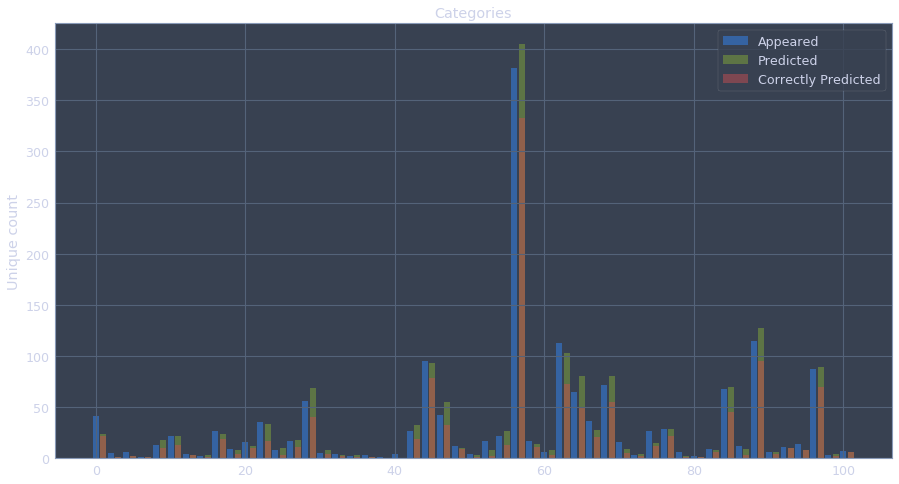

In [108]:
plt.figure(figsize=(15,8))
#plt.yscale('log')

plt.bar(yPosition, pod, alpha=0.7, label='Appeared')
plt.bar(yPosition, podp, alpha=0.5, label='Predicted')
plt.bar(yPosition, podc, alpha=0.5, label='Correctly Predicted')

plt.ylabel('Unique count')
plt.title('Categories')
plt.legend()
 
plt.show()

## Export Coefficients
Predict results for the test data and output results in a `output_test.csv`.

In [21]:
DROP_RATES = [0.3,0.4]
NB_FILTERS = 512
REDUCED_DIM = 100

BATCH_SIZE = 32
EPOCHS = 10

In [22]:
pca = PCA(n_components=REDUCED_DIM)
reducedEmbeddings = pca.fit_transform(embeddings)

In [23]:
model = CustomModel(verbose=True, nbCategories=NB_CATEGORIES, trainable=TRAINABLE)
model.buildCNN2D(reducedEmbeddings, drop_rates=DROP_RATES, nb_filters=NB_FILTERS)
# model.model.load_weights('./../models_checkpoints/weights-04-0.72.hdf5')

In [24]:
model.train(x, y, epochs=EPOCHS, batch_size=BATCH_SIZE)
EPOCHS = 5
BATCH_SIZE = 256
model.train(x, y, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/10
8028/8028 [==============================] - 24s 3ms/step - loss: 2.4284 - acc: 0.4119
Epoch 2/10
8028/8028 [==============================] - 28s 3ms/step - loss: 1.5912 - acc: 0.5934
Epoch 3/10
8028/8028 [==============================] - 28s 4ms/step - loss: 1.2257 - acc: 0.6731
Epoch 4/10
8028/8028 [==============================] - 28s 4ms/step - loss: 0.9875 - acc: 0.7312
Epoch 5/10
8028/8028 [==============================] - 29s 4ms/step - loss: 0.8107 - acc: 0.7719
Epoch 6/10
8028/8028 [==============================] - 28s 4ms/step - loss: 0.6554 - acc: 0.8088
Epoch 7/10
8028/8028 [==============================] - 29s 4ms/step - loss: 0.5348 - acc: 0.8433
Epoch 8/10
8028/8028 [==============================] - 29s 4ms/step - loss: 0.4176 - acc: 0.8749
Epoch 9/10
8028/8028 [==============================] - 28s 3ms/step - loss: 0.3786 - acc: 0.8869
Epoch 10/10
8028/8028 [==============================] - 28s 4ms/step - loss: 0.3185 - acc: 0.9035
Epoch 1/5
8028/8028

In [25]:
exportY = model.predict(xTest)
exportY = np.argmax(exportY, axis=1)

In [26]:
with open(os.path.join(dataDirPath, 'output_test.csv'), 'w+') as f:
    f.write('ID;intention\n')

    for i, p in enumerate(exportY):
        f.write('{};{}\n'.format(str(i), str(p)))

In [27]:
exportY

array([29, 32, 28, ..., 28, 42, 34])